In [ ]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import pandas as pd
import random

In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/06-season-masking-on-not-transformed-data.csv")
# df.drop(columns=["solarenergy",
#                  "orographic_precipitation_potential",
#                  "urban_heat_island_effect_refined",
#                  "valley_temperature_inversion_index",
#                  "windspeed","winddir","season",
#                  "winddir_cos","winddir_sin",'dew',"month_cos",
#                  "month_sin","temp"],inplace=True)
df = pd.read_csv("/content/drive/MyDrive/Kathmandu-Precipitation/data/Outlier-removed-dataset.csv")

In [ ]:
features = [ i for i in df.columns if i not in ["precipitation","datetime"]]
target = ["precipitation"]
X = df[features]

y = df[target]

In [ ]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
# Converting X_train, X_test, y_train, y_test to NumPy arrays and then to PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [54]:
# # #grid search cv
# # # Define the KNN regressor
# best_params = {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}

knn = KNeighborsRegressor()


# # # Define the hyperparameter grid
param_grid = {
    'n_neighbors': [random.randint(15, 1000) for _ in range(100)],  # Try different values of k
    'weights': ['uniform', 'distance'],  # Uniform or distance-based weighting
    'p': [1, 2,3]  # Manhattan (p=1) or Euclidean (p=2) distance or Minkowski distance(p=3)
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [55]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best Parameters: {'n_neighbors': 105, 'p': 1, 'weights': 'uniform'}
Best Negative MSE: -17.534296417236327


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-19.65272465 -18.6439901  -19.86772594 -18.70123486 -19.92406006
 -18.70109782 -18.30713005 -17.97132233 -18.38589878 -17.98686186
 -18.42612572 -18.01011006 -18.86544514 -18.21790693 -18.9626852
 -18.24784689 -19.01192551 -18.27082289 -18.88020897 -18.22712506
 -18.99244709 -18.26310216 -19.05793324 -18.28896742 -18.67920647
 -18.12496113 -18.76362514 -18.1600891  -18.75377045 -18.16150406
 -18.58387108 -18.08259073 -18.6428545  -18.10521086 -18.68805828
 -18.12603397 -18.24957714 -17.9437725  -18.30569477 -17.95159619
 -18.32854271 -17.96428704 -18.85951843 -18.21535554 -18.96639652
 -18.24854293 -18.99970531 -18.26584392 -19.84724236 -18.7147308
 -20.01082745 -18.76303297 -20.05008183 -18.75578739 -19.09733467
 -18.36163853 -19.43702126 -18.43053856 -19.47662354 -18.43074169
 -18.92992382 -18.25504909 -19.08086548 -18.2973439  -19.12439251
 -1

"""
####Fitting 5 folds for each of 6000 candidates, totalling 30000 fits
####Best Parameters: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
####Best Negative MSE: -147.36429715972773


## using IQR on target we got
## Best Parameters: {'n_neighbors': 105, 'p': 1, 'weights': 'uniform'}

In [56]:
def knn_predict(X_train, y_train, X_test, k):
    """
    Perform KNN regression prediction.

    Args:
        X_train (torch.Tensor): Training features (n_samples, n_features).
        y_train (torch.Tensor): Training targets (n_samples, 1).
        X_test (torch.Tensor): Test features (m_samples, n_features).
        k (int): Number of neighbors.

    Returns:
        torch.Tensor: Predicted values for X_test.
    """
    predictions = []

    for test_point in X_test:
        # Compute Euclidean distances between test_point and all training points
        distances = torch.norm(X_train - test_point, dim=1)

        # Get indices of the k nearest neighbors
        _, indices = torch.topk(distances, k, largest=False)

        # Get the target values of the k nearest neighbors
        k_nearest_targets = y_train[indices]

        # Predict the mean of the k nearest neighbors' target values
        prediction = torch.mean(k_nearest_targets)
        predictions.append(prediction)

    return torch.tensor(predictions)

In [62]:
k = 105  # Number of neighbors
y_pred = knn_predict(X_train, y_train, X_test, k)

# Evaluate using Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 2.8649


In [63]:
#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Square root of MSE

# Print metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 2.8649
Root Mean Squared Error (RMSE): 3.9978


In [59]:
# Example: Check if target variable was scaled
print("Actual Precipitation Range:", df['precipitation'].min(), "to", df['precipitation'].max())
print("Predicted Precipitation Range:", y_pred.min(), "to", y_pred.max())

Actual Precipitation Range: 0.0 to 18.9
Predicted Precipitation Range: tensor(2.2759) to tensor(3.3601)


In [60]:
print(y_test.shape)
print(y_pred.shape)

torch.Size([303, 1])
torch.Size([303])


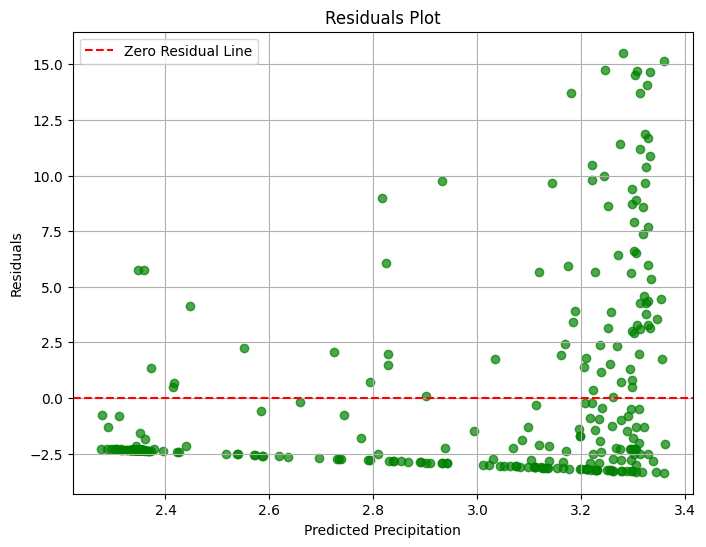

In [61]:
import matplotlib.pyplot as plt


# Compute residuals
residuals = y_test.squeeze(1) - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--', label="Zero Residual Line")
plt.xlabel("Predicted Precipitation")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.legend()
plt.grid()
plt.show()